In [12]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [13]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [14]:
NUM_CLASSES = 5

# 学習データ読み込み

In [15]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [16]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [19]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [20]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [21]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [22]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


24/32 [=====================>........] - ETA: 0s - loss: 1.5472 - accuracy: 0.2770
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 2s 23ms/step - loss: 1.5408 - accuracy: 0.2833 - val_loss: 1.4704 - val_accuracy: 0.3169
Epoch 2/1000
24/32 [=====================>........] - ETA: 0s - loss: 1.4792 - accuracy: 0.3197
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 0s 9ms/step - loss: 1.4773 - accuracy: 0.3234 - val_loss: 1.4176 - val_accuracy: 0.3796
Epoch 3/1000
25/32 [======================>.......] - ETA: 0s - loss: 1.4456 - accuracy: 0.3434
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 1.4376 - accuracy: 0.3547 - val_loss: 1.3627 - val_accuracy: 0.5004
Epoch 4/1000
24/32 [=====================>........] - ETA: 0s - loss: 1.3913 - accuracy: 0.4066
Epoch 4: sav

In [23]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 4ms/step - loss: 0.2840 - accuracy: 0.9485


In [24]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [25]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 151ms/step
[1.0431287e-01 2.8642580e-02 3.8533844e-03 9.8632852e-05 8.6309254e-01]
4


# 混同行列

42/42 [==============================] - 0s 2ms/step


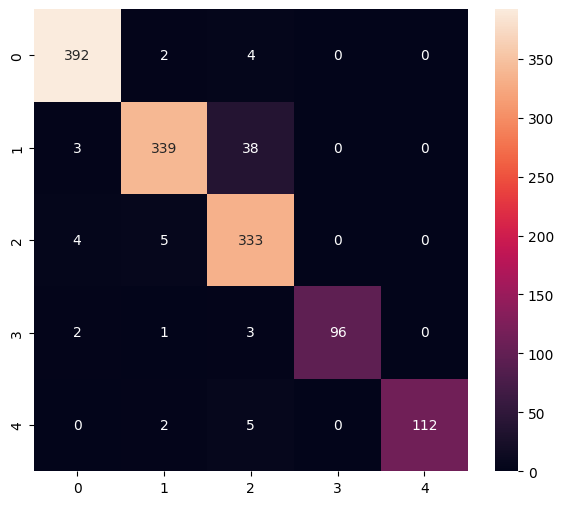

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       398
           1       0.97      0.89      0.93       380
           2       0.87      0.97      0.92       342
           3       1.00      0.94      0.97       102
           4       1.00      0.94      0.97       119

    accuracy                           0.95      1341
   macro avg       0.96      0.95      0.95      1341
weighted avg       0.95      0.95      0.95      1341



In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [27]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [28]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2024-05-24 10:12:34.595247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,42]
	 [[{{node input_2}}]]
2024-05-24 10:12:34.776601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,42]
	 [[{{node inputs}}]]
2024-05-24 10:12:34.817631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,42]
	 [[{{node input_2}}]]
2024-05-24 10:1

INFO:tensorflow:Assets written to: /tmp/tmpc6s43inv/assets


INFO:tensorflow:Assets written to: /tmp/tmpc6s43inv/assets
2024-05-24 10:12:37.672679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-24 10:12:37.672773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-24 10:12:37.673777: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc6s43inv
2024-05-24 10:12:37.676746: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-05-24 10:12:37.676798: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc6s43inv
2024-05-24 10:12:37.691233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-05-24 10:12:37.692852: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-24 10:12:37.787359: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

6616

# 推論テスト

In [29]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [30]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [31]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [32]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 895 µs, sys: 76 µs, total: 971 µs
Wall time: 1.06 ms


In [33]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.04312815e-01 2.86425855e-02 3.85338976e-03 9.86329469e-05
 8.63092542e-01]
4
